# Fraudulent Activities 

### OBJECTIVES

E-commerce websites are more and more used, some e-shops have to handle thousands or even millions of transactions a day. This opens room for potential fraudulent activities like money laundering or, use of stolen credit card etc. 

This Notebook aim's at computing the probability of a transaction being fraudulent thanks to Machine Learning.
 
Datasets :
```python
Fraud_Data.csv
IpAddress_to_Country.csv
```


## Import Libraries

In [2]:
import pandas as pd 
import numpy as np
from numpy import mean
import seaborn as sns 
import matplotlib.pyplot as plt

from datetime import timedelta, datetime, tzinfo, timezone

from sklearn.utils import class_weight

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import f1_score


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [4]:
fraud_data = pd.read_csv('dataset/Fraud_Data.csv')
ip_data = pd.read_csv('dataset/IpAddress_to_Country.csv')

# Exploratory Analysis

In [13]:
fraud_data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


the class column tells us if the transaction if fraudulent '1' or regular '0'

In [30]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         151112 non-null  int64 
 1   signup_time     151112 non-null  object
 2   purchase_time   151112 non-null  object
 3   purchase_value  151112 non-null  int64 
 4   device_id       151112 non-null  object
 5   source          151112 non-null  object
 6   browser         151112 non-null  object
 7   sex             151112 non-null  object
 8   age             151112 non-null  int64 
 9   ip_address      151112 non-null  object
 10  class           151112 non-null  int64 
 11  country_name    151112 non-null  object
dtypes: int64(4), object(8)
memory usage: 13.8+ MB


As we can see there's no missing data

In [15]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


## Transform Ip to Country

The Ip Adress is not usefull as is, nevertheless we can fetch the countries where the ip come from thanks to the data in 
```python
IpAddress_to_Country.csv
```
Let's write a function to convert Ips into countries

In [3]:
def transform_ip(arg) :
    try :
        return ip_data.country[(ip_data.lower_bound_ip_address < arg) & 
        (ip_data.upper_bound_ip_address > arg)].iloc[0]
        
    except IndexError :
        return "Unknown Country"  

In [4]:
fraud_data["country_name"] = fraud_data['ip_address'].apply(transform_ip)
fraud_data.to_csv('fraud_data_de.csv', index = False)

In [104]:
fraud_data = pd.read_csv('fraud_data_de.csv')

In [91]:
fraud_data.head(2)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States


## Date time

In [215]:
# We'll need to convert *signup_time* and *purchase_time* columns in datetime format
fraud_data.loc[:, 'signup_time'] =  pd.to_datetime(fraud_data.loc[:, 'signup_time'], format='%Y-%m-%d %H:%M:%S')
fraud_data.loc[:, 'purchase_time'] =  pd.to_datetime(fraud_data.loc[:, 'purchase_time'], format='%Y-%m-%d %H:%M:%S')

In [150]:
sns.set(style="ticks", palette="pastel")

## Data Viz

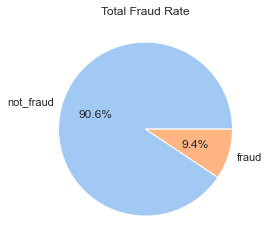

In [75]:
## fraud rate

plt.pie(fraud_data['class'].value_counts(), labels = ['not_fraud', 'fraud'], autopct='%1.1f%%')
plt.title("Total Fraud Rate")
plt.show()

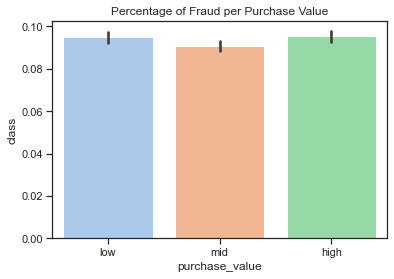

In [77]:
#  Purchase Value
purchase_value_discretized = pd.qcut(fraud_data['purchase_value'], 3, ['low','mid','high'])
sns.barplot( x  = purchase_value_discretized, y = fraud_data['class'])
plt.title("Percentage of Fraud per Purchase Value")
plt.show()

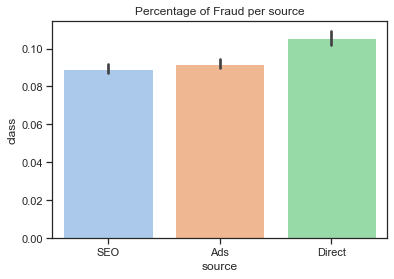

In [78]:
# source
sns.barplot(data = fraud_data, x  = 'source' , y = 'class')
plt.title("Percentage of Fraud per source")
plt.show()

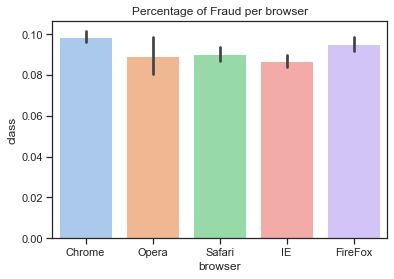

In [79]:
# browser
sns.barplot(data = fraud_data, x  = 'browser' , y = 'class')
plt.title("Percentage of Fraud per browser")
plt.show()

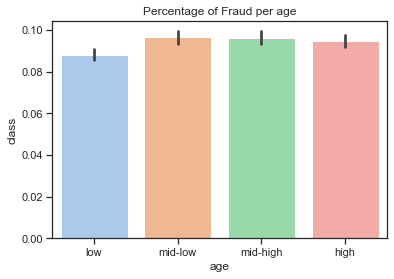

In [83]:
#  age
age_discretized = pd.qcut(fraud_data['age'], 4, ['low','mid-low', 'mid-high','high'])
sns.barplot( x  = age_discretized, y = fraud_data['class'])
plt.title("Percentage of Fraud per age")
plt.show()

## Feature Engineering

In [94]:
# country name
print('Number of countries :', fraud_data['country_name'].nunique())
print('--------------------')
fraud_data['country_name'].value_counts()
#sns.barplot(data = fraud_data, x  = 'country_name' , y = 'class')

Number of countries : 182
--------------------


United States                    58049
Unknown Country                  21966
China                            12038
Japan                             7306
United Kingdom                    4490
                                 ...  
Madagascar                           1
Tajikistan                           1
Dominica                             1
Bonaire; Sint Eustatius; Saba        1
Cape Verde                           1
Name: country_name, Length: 182, dtype: int64

There are many countries with only 1 occurence, we'll need to group them, we also make the choice to regroup together all the countries that have less than 5 occurences in the dataset

In [106]:

value_counts = fraud_data['country_name'].value_counts()
single_values = value_counts[value_counts <5].index

mask = fraud_data['country_name'].isin(single_values)
fraud_data.loc[mask, 'country_name'] = 'Other'

In [107]:
fraud_data['country_name'].value_counts()

United States      58049
Unknown Country    21966
China              12038
Japan               7306
United Kingdom      4490
                   ...  
Zimbabwe               6
Cote D'ivoire          6
Afghanistan            6
Cameroon               5
New Caledonia          5
Name: country_name, Length: 139, dtype: int64

In [109]:
country_fraud = fraud_data.groupby('country_name')['class'].agg({'mean','count'}).sort_values(by='mean', ascending = False)
country_fraud

,mean,count
country_name,,
Namibia,0.434783,23
Sri Lanka,0.419355,31
Luxembourg,0.388889,72
Ecuador,0.264151,106
Tunisia,0.262712,118
...,...,...
Puerto Rico,0.000000,30
Qatar,0.000000,25
Guam,0.000000,7


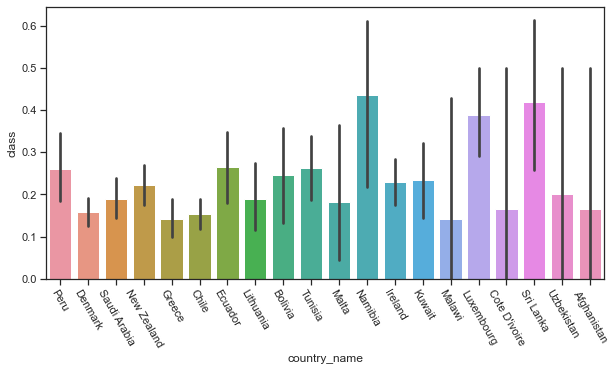

In [151]:
highest_20_countries = country_fraud.index[:20]
data_countries = fraud_data[fraud_data['country_name'].isin(highest_20_countries)]

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = data_countries, x = 'country_name', y = 'class', ax = ax)
ax.xaxis.set_tick_params(rotation=-60)

In [ ]:
sns.catplot(fraud_data['device_id'])
#sns.histplot(data = fraud_data['ip_address'])

In [203]:
#device
df_device = fraud_data.groupby('device_id').agg({'device_id': 'count','class': np.mean})
df_device.columns = ['device_id_count', 'fraud_percentage']
df_device = df_device.sort_values(by = 'device_id_count', ascending = False)
df_device.head(15)

,device_id_count,fraud_percentage
device_id,,
KIPFSCNUGOLDP,20,0.950000
NGQCKIADMZORL,20,0.950000
CQTUVBYIWWWBC,20,0.950000
ITUMJCKWEYNDD,20,0.950000
EQYVNEGOFLAWK,20,0.950000
ZUSVMDEZRBDTX,20,0.950000
BWSMVSLCJXMCM,19,0.947368
IGKYVZDBEGALB,19,0.947368
EGLGSEGYPMMAM,19,0.947368


It seems that the more a device_id makes purchases the more these purchases are likely to be fraudulents
We suspect that these fraudulent purchases are made in a short window of time, probably by bots

In [206]:
fraud_data.loc[fraud_data['device_id'] == 'NGQCKIADMZORL',:].head(8)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
13973,278428,2015-01-03 13:10:40,2015-01-03 13:10:41,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17397,53591,2015-01-03 13:10:43,2015-01-03 13:10:44,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
17551,384595,2015-01-03 13:10:35,2015-01-03 13:10:36,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
19324,181018,2015-01-03 13:10:41,2015-01-03 13:10:42,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23254,226646,2015-01-03 13:10:51,2015-01-03 13:10:52,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
23670,381483,2015-01-03 13:10:49,2015-01-03 13:10:50,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
27888,277313,2015-01-03 13:10:45,2015-01-03 13:10:46,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand
62937,186785,2015-01-03 13:10:52,2015-01-03 13:10:53,42,NGQCKIADMZORL,SEO,FireFox,F,34,2.050964e+09,1,New Zealand


for the device NGQCKIADMZORL we can see a purchase made almost every second 

In [208]:
device_count = fraud_data['device_id'].value_counts()
fraud_data['n_device_occur'] = fraud_data['device_id'].apply(lambda x : device_count[x] )

In [209]:
total_amount_perIP = fraud_data.groupby('ip_address')['purchase_value'].sum()
fraud_data['amount_purchase_per_ip'] = fraud_data['ip_address'].apply(lambda x: total_amount_perIP[x])
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name,n_device_occur,amount_purchase_per_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,34
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,16
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,180
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown Country,1,44
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,39


In [220]:
data = fraud_data.copy()
to_remove = ['ip_address', 'device_id', 'user_id', 'purchase_value']
data = data[[c for c in data.columns if c not in to_remove  ]]

In [221]:
data.head(5)

,signup_time,purchase_time,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip
0,2015-02-24 22:55:49,2015-04-18 02:47:11,SEO,Chrome,M,39,0,Japan,1,34
1,2015-06-07 20:39:50,2015-06-08 01:38:54,Ads,Chrome,F,53,0,United States,1,16
2,2015-01-01 18:52:44,2015-01-01 18:52:45,SEO,Opera,M,53,1,United States,12,180
3,2015-04-28 21:13:25,2015-05-04 13:54:50,SEO,Safari,M,41,0,Unknown Country,1,44
4,2015-07-21 07:09:52,2015-09-09 18:40:53,Ads,Safari,M,45,0,United States,1,39


In [222]:
col_names = ['purchase_year', 'purchase_month', 'purchase_day', 'purchase_day_name' 'purchase_hour', 'purchase_min', 'purchase_sec']

data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day
data['signup_day_name'] = data['signup_time'].dt.day_name()

data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day
data['purchase_day_name'] = data['purchase_time'].dt.day_name()

In [223]:

seconds_in_day = 24 * 60 * 60
to_remove = ['signup_time', 'purchase_time']

data['time_to_purchase'] = data['purchase_time'] - data['signup_time']

data['time_to_purchase'] = data['time_to_purchase'].dt.days * seconds_in_day + data['time_to_purchase'].dt.seconds

data['time_to_purchase'] = pd.qcut(data['time_to_purchase'], 10, labels = False, duplicates = 'drop')

data = data[[c for c in data.columns if c not in to_remove  ]] 

In [319]:
display(data.head(5))

,source,browser,sex,age,class,country_name,n_device_occur,amount_purchase_per_ip,signup_month,signup_day,signup_day_name,purchase_month,purchase_day,purchase_day_name,time_to_purchase,purchase_over_time
0,SEO,Chrome,M,39,0,Japan,1,34,2,24,Tuesday,4,18,Saturday,4506682,0.007544
1,Ads,Chrome,F,53,0,United States,1,16,6,7,Sunday,6,8,Monday,17944,0.891663
2,SEO,Opera,M,53,1,United States,12,180,1,1,Thursday,1,1,Thursday,1,180000.000000
3,SEO,Safari,M,41,0,Unknown Country,1,44,4,28,Tuesday,5,4,Monday,492085,0.089415
4,Ads,Safari,M,45,0,United States,1,39,7,21,Tuesday,9,9,Wednesday,4361461,0.008942


Now it might be interesting to compute the amount of purchase over the time to purchase

In [332]:
data['purchase_over_time'] = 1000* data['amount_purchase_per_ip'] / data['time_to_purchase']

## Viz Engineered Features

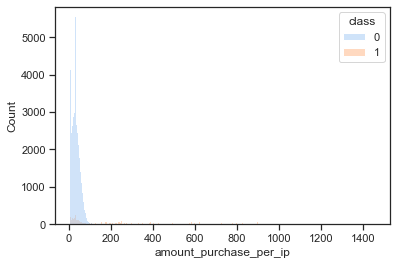

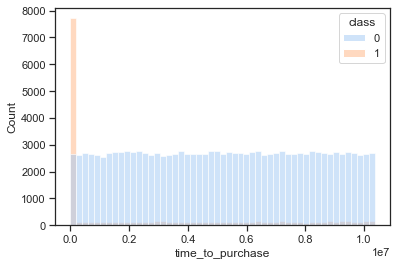

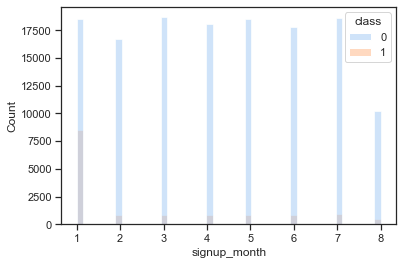

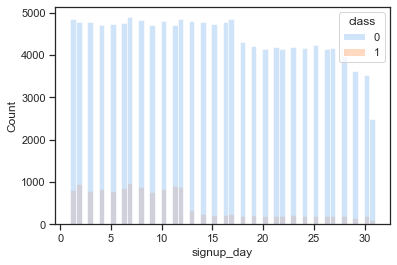

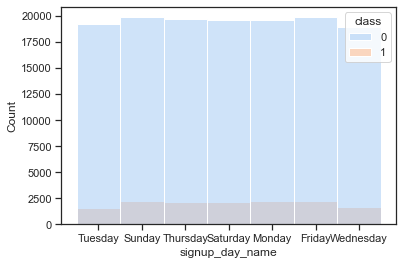

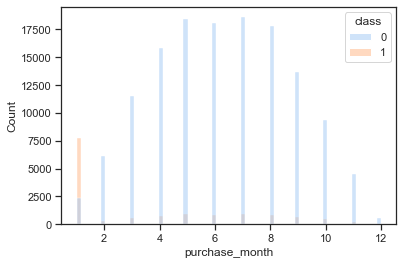

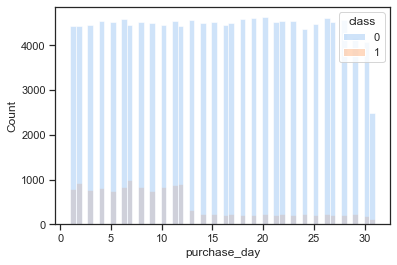

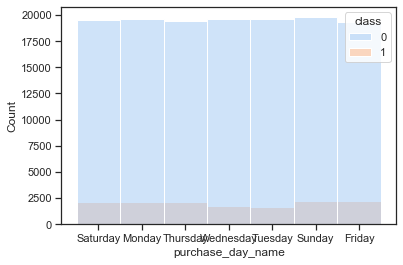

In [329]:
to_viz = ['amount_purchase_per_ip', 'time_to_purchase',	'signup_month',	'signup_day', 'signup_day_name', 'purchase_month', 'purchase_day',	'purchase_day_name']

for c in to_viz:
    plt.figure()
    sns.histplot(data = data, x = c , hue='class')
    plt.plot()

## Preprocessing

In [333]:
to_remove = ['time_to_purchase','amount_purchase_per_ip', 'class']

X = data[[c for c in data.columns if c not in to_remove]] 
Y = data['class']

X_b = X.copy()
Y_b = Y.copy()

X.columns

Index(['source', 'browser', 'sex', 'age', 'country_name', 'n_device_occur',
       'signup_month', 'signup_day', 'signup_day_name', 'purchase_month',
       'purchase_day', 'purchase_day_name', 'purchase_over_time'],
      dtype='object')

In [334]:
#cat_column = [c for c in data.columns.values if data[c].dtype == 'object']
cat_column_index = [X.columns.get_loc(c) for c in X.columns if X[c].dtype == 'object']  #selecting indexes of the categorical variables
num_column_index = [X.columns.get_loc(c) for c in X.columns if X[c].dtype != 'object'] #selecting indexes of the numerical variables

In [335]:
len(cat_column_index) + len (num_column_index)

13

In [336]:
X = X.values
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state= 59, stratify = Y)

In [337]:
# Create pipeline for numeric features
numeric_features = num_column_index 
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = cat_column_index 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(drop='first')) 
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print('Done')

Done


## Logistic Regression

In [338]:
# Train model
model = LogisticRegression(C=0.91, class_weight={0:0.6, 1:1}, dual=False, fit_intercept=True,intercept_scaling=1, l1_ratio=None, max_iter=500,multi_class='auto', n_jobs=None, penalty='l2',random_state=None, solver='lbfgs', tol=0.0001, verbose=0,warm_start=False)

model.fit(X_train, Y_train)
print("...Done.")

...Done.


In [339]:
# Predictions on sets
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [343]:
from sklearn.metrics import accuracy_score
# Print scores
print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

Accuracy on training set :  0.9550414016163588
Accuracy on test set :  0.9555967309664825


In [344]:
print('f1 test :',f1_score(Y_test, Y_test_pred))
print('f1 train :',f1_score(Y_train, Y_train_pred))

f1 test : 0.6958295557570262
f1 train : 0.6909297696900769


[]

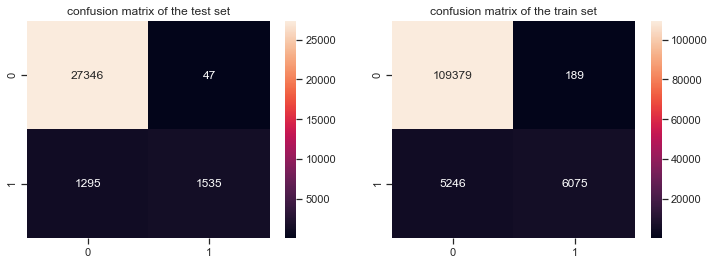

In [346]:
# Create confusion Matrix

cm_test = metrics.confusion_matrix(Y_test, Y_test_pred) 
cm_train = metrics.confusion_matrix(Y_train, Y_train_pred) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" )
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" )

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [152]:
scores_train = cross_val_score(model, X_train, Y_train, cv=10, scoring='f1')
#predictions = cross_val_predict(model, X_train, Y_train, cv = 10)

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())

[0.68364349 0.68914229 0.6765286  0.68083004 0.68150346 0.67363184
 0.66733068 0.66930302 0.68129676 0.6471183 ]
score min : 0.647118301314459
score max : 0.6891422905304909


In [332]:
# define grid
#cw_params = [{0:0.6,1:1}]
cw_params = [{0:i, 1:1} for i in np.arange(0.60, 0.7, 0.001)]
#C_param = np.arange(0.9, 1.01, 0.01)
param_grid = dict(class_weight = cw_params)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=19)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
grid_result = grid.fit(X_test, Y_test)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.619676 using {'class_weight': {0: 0.6, 1: 1}}
0.619676 (0.030599) with: {'class_weight': {0: 0.6, 1: 1}}
0.619130 (0.030941) with: {'class_weight': {0: 0.601, 1: 1}}
0.618802 (0.031062) with: {'class_weight': {0: 0.602, 1: 1}}
0.618388 (0.031035) with: {'class_weight': {0: 0.603, 1: 1}}
0.618291 (0.030889) with: {'class_weight': {0: 0.604, 1: 1}}
0.617897 (0.030454) with: {'class_weight': {0: 0.605, 1: 1}}
0.617384 (0.029690) with: {'class_weight': {0: 0.606, 1: 1}}
0.617384 (0.029690) with: {'class_weight': {0: 0.607, 1: 1}}
0.617271 (0.029957) with: {'class_weight': {0: 0.608, 1: 1}}
0.616746 (0.030221) with: {'class_weight': {0: 0.609, 1: 1}}
0.616338 (0.029953) with: {'class_weight': {0: 0.61, 1: 1}}
0.615633 (0.029324) with: {'class_weight': {0: 0.611, 1: 1}}
0.614036 (0.027766) with: {'class_weight': {0: 0.612, 1: 1}}
0.612981 (0.027998) with: {'class_weight': {0: 0.613, 1: 1}}
0.613156 (0.027787) with: {'class_weight': {0: 0.614, 1: 1}}
0.611998 (0.027833) with: {'class_

## Decision Tree

In [347]:
decision_tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth = 5, min_samples_split=2,
                              min_samples_leaf=9, min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
                              max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None,
                              presort='deprecated', ccp_alpha=0.0)



In [348]:
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9)

In [349]:
print('f1 test :',f1_score(Y_test, decision_tree.predict(X_test) ))
print('f1 train :',f1_score(Y_train, decision_tree.predict(X_train) ))

f1 test : 0.702132538408622
f1 train : 0.6979873490511789


In [182]:
scores_train = cross_val_score(decision_tree, X_train, Y_train, cv=10, scoring='f1')

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())

[0.7035533  0.7072552  0.70426829 0.70091556 0.70229008 0.69325153
 0.69600819 0.69285714 0.69556349 0.66457352]
score min : 0.6645735217163787
score max : 0.7072552004058854


In [262]:


# define grid

max_depth = np.arange(5,10,1)
min_samples_split = np.arange(2,10,1)
min_samples_leaf = np.arange(8,10,1)
criterion = ['entropy', 'gini']


param_grid = dict(criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 19)
grid = GridSearchCV(estimator = decision_tree, param_grid = param_grid, n_jobs=-1, cv=cv, scoring='f1')


grid_result = grid.fit(X_test, Y_test)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Best: 0.705338 using {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 5}


## Random Forest

In [350]:

rdm_forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=7, min_samples_split=2, min_samples_leaf=3, 
                       random_state=2,class_weight={0:0.2, 1:1}, ccp_alpha=0.0, max_samples=None)

rdm_forest.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 1}, max_depth=7,
                       min_samples_leaf=3, random_state=2)

In [351]:
print('f1 test :',f1_score(Y_test, rdm_forest.predict(X_test) ))
print('f1 train :',f1_score(Y_train, rdm_forest.predict(X_train) ))

f1 test : 0.6952209197475203
f1 train : 0.6912130110684436
